In [11]:
import glob
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import rocks

rocks.set_log_level("error")
import time as t


from astropy.time import Time
import requests
import io

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import angular_separation

from scipy.signal import argrelextrema

import ssptools
from figure_mask import compute_mask, print_statistics, compute_mask_spin

# Get ZTF fit

In [2]:
# Local Configuration
data_fink = "../"
bft_file = os.path.join(data_fink, "data", "ssoBFT-latest.parquet")

In [3]:
# ZTF filters 1: g, 2: r
filters = {"1": "g", "2": "r"}

S_color = {"g": -0.3928, "r": 0.2913}
sun_color = {"g": -0.3044, "r": 0.1903}

color_C = -(sun_color["g"] - sun_color["r"])
color_S = -(S_color["g"] - S_color["r"])

fink_colors = ["#15284F", "#F5622E"]

V_minus_g = -0.2833
V_minus_r = 0.1777

In [4]:
data = pd.read_parquet(os.path.join(data_fink, "data", "ztf", "sso_ZTF.parquet"))

In [5]:
data.columns

Index(['ssnamenr', 'HG_chi2red', 'HG_status', 'HG_fit', 'HG_rms', 'HG_rms_g',
       'HG_rms_r', 'HG_median_error_phot', 'HG_median_error_phot_1',
       'HG_median_error_phot_2', 'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g',
       'HG_H_r', 'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_flag', 'HG1G2_chi2red',
       'HG1G2_status', 'HG1G2_fit', 'HG1G2_rms', 'HG1G2_rms_g', 'HG1G2_rms_r',
       'HG1G2_median_error_phot', 'HG1G2_median_error_phot_1',
       'HG1G2_median_error_phot_2', 'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g',
       'HG1G2_dG1_g', 'HG1G2_G2_g', 'HG1G2_dG2_g', 'HG1G2_H_r', 'HG1G2_dH_r',
       'HG1G2_G1_r', 'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_flag',
       'SHG1G2_chi2red', 'SHG1G2_min_cos_lambda', 'SHG1G2_mean_cos_lambda',
       'SHG1G2_max_cos_lambda', 'SHG1G2_status', 'SHG1G2_fit', 'SHG1G2_rms',
       'SHG1G2_rms_g', 'SHG1G2_rms_r', 'SHG1G2_median_error_phot',
       'SHG1G2_median_error_phot_1', 'SHG1G2_median_error_phot_2', 'n_obs',
       'n_obs_g', 'n_obs_r', 

In [6]:
data["SHG1G2_dSpin"] = np.sqrt(
    (data["SHG1G2_dalpha0"] * np.cos(np.radians(data["SHG1G2_delta0"]))) ** 2
    + data["SHG1G2_ddelta0"] ** 2
)


# # Remove solutions above 90 deg of latitude
cond = data.SHG1G2_delta0 > 90
data.loc[cond, "SHG1G2_delta0"] = 90
print(f"above 90: {len(data[cond])} ")

cond = data.SHG1G2_delta0 < -90
data.loc[cond, "SHG1G2_delta0"] = -90
print(f"below 90: {len(data[cond])} ")

above 90: 0 
below 90: 0 


In [7]:
cols = [
    "sso_number",
    "sso_name",
    "sso_class",
    "orbital_elements.semi_major_axis.value",
    "orbital_elements.eccentricity.value",
    "orbital_elements.inclination.value",
    "orbital_elements.node_longitude.value",
    "orbital_elements.perihelion_argument.value",
    "orbital_elements.mean_anomaly.value",
    "orbital_elements.mean_motion.value",
    "family.family_number",
    "family.family_name",
    "proper_elements.proper_semi_major_axis.value",
    "proper_elements.proper_eccentricity.value",
    "proper_elements.proper_inclination.value",
    "proper_elements.proper_sine_inclination.value",
    "tisserand_parameters.Jupiter.value",
    "albedo.value",
    "absolute_magnitude.value",
    "diameter.value",
    "taxonomy.class",
    "taxonomy.complex",
    "taxonomy.waverange",
    "taxonomy.scheme",
    "taxonomy.technique",
    "colors.g-r.color.value",
    "colors.g-r.color.error.min",
    "colors.g-r.color.error.max",
    "colors.g-r.facility",
    "colors.g-r.observer",
    "colors.g-r.epoch",
    "colors.g-r.delta_time",
    "colors.g-r.id_filter_1",
    "colors.g-r.id_filter_2",
    "colors.g-r.phot_sys",
    "colors.g-r.technique",
    "spins.1.obliquity",
    "spins.1.RA0.value",
    "spins.1.DEC0.value",
    "spins.1.RA0.error.max",
    "spins.1.DEC0.error.max",
    "spins.1.long.value",
    "spins.1.lat.value",
    "spins.1.technique",
    "spins.2.obliquity",
    "spins.2.RA0.value",
    "spins.2.DEC0.value",
    "spins.2.RA0.error.max",
    "spins.2.DEC0.error.max",
    "spins.2.long.value",
    "spins.2.lat.value",
    "spins.2.technique",
    "spins.3.obliquity",
    "spins.3.RA0.value",
    "spins.3.DEC0.value",
    "spins.3.RA0.error.max",
    "spins.3.DEC0.error.max",
    "spins.3.long.value",
    "spins.3.lat.value",
    "spins.3.technique",
    "spins.4.obliquity",
    "spins.4.RA0.value",
    "spins.4.DEC0.value",
    "spins.4.RA0.error.max",
    "spins.4.DEC0.error.max",
    "spins.4.long.value",
    "spins.4.lat.value",
    "spins.4.technique",
]
bft = pd.read_parquet(bft_file, columns=cols)

In [8]:
data = data.merge(bft, left_on="name", right_on="sso_name", how="left")

In [9]:
# data

In [13]:
mask_SHG1G2_union = compute_mask(data, model='SHG1G2', kind='union')
mask_HG1G2_union = compute_mask(data, model='HG1G2', kind='union')
mask_HG_union = compute_mask(data, model='HG', kind='union')

mask_SHG1G2_inter = compute_mask(data, model='SHG1G2', kind='inter')
mask_HG1G2_inter = compute_mask(data, model='HG1G2', kind='inter')
mask_HG_inter = compute_mask(data, model='HG', kind='inter')

maskFINK_inter = compute_mask(data, model='FINK', kind='inter')
maskFINK_union = compute_mask(data, model='FINK', kind='union')

for model in ['HG', 'HG1G2', 'SHG1G2', 'FINK']:
    print_statistics(data, model)
    print()

  All data       : 122675  (100.00%)
  Mask HG (g∩r) : 120023  ( 97.84%)
  Mask HG (gUr) : 120024  ( 97.84%)

  All data       : 122675  (100.00%)
  Mask HG1G2 (g∩r) :  47177  ( 38.46%)
  Mask HG1G2 (gUr) :  85363  ( 69.58%)

  All data       : 122675  (100.00%)
  Mask SHG1G2 (g∩r) :  64279  ( 52.40%)
  Mask SHG1G2 (gUr) :  97579  ( 79.54%)

  All data       : 122675  (100.00%)
  Mask FINK (g∩r) :  63092  ( 51.43%)
  Mask FINK (gUr) :  95593  ( 77.92%)



# Abs mag

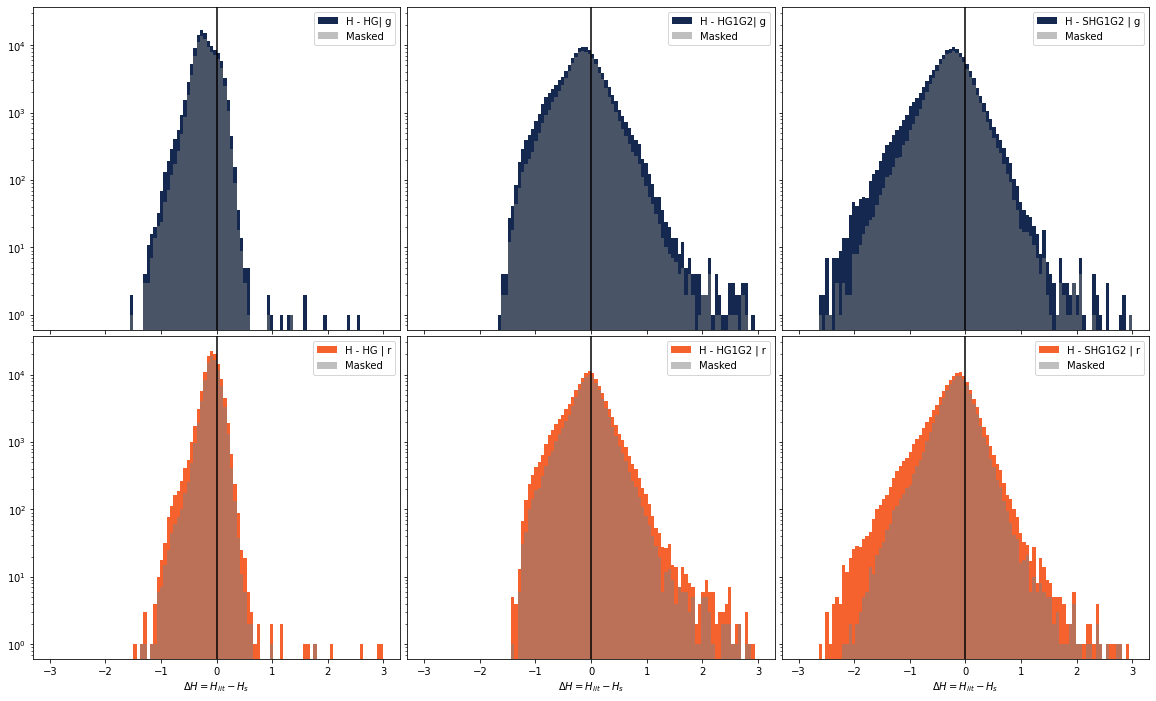

In [15]:
maskFINK = maskFINK_union

# Different colors
fig, ax = plt.subplots(
    2,
    3,
    figsize=(20, 12),
    sharex=True,
    sharey=True,
    gridspec_kw={"hspace": 0.02, "wspace": 0.02},
)

r = [-3, 3]
b = 100


# HG
x = (data["absolute_magnitude.value"] - data.HG_H_g) - V_minus_g
ax[0, 0].hist(x, range=r, bins=b, label="H - HG| g", color=fink_colors[0])
ax[0, 0].hist(x[maskFINK], range=r, bins=b, label="Masked", color="grey", alpha=0.5)

x = (data["absolute_magnitude.value"] - data.HG_H_r) - V_minus_r
ax[1, 0].hist(x, range=r, bins=b, label="H - HG | r", color=fink_colors[1])
ax[1, 0].hist(x[maskFINK], range=r, bins=b, label="Masked", color="grey", alpha=0.5)


# HG1G2
x = (data["absolute_magnitude.value"] - data.HG1G2_H_g) - V_minus_g
ax[0, 1].hist(x, range=r, bins=b, label="H - HG1G2| g", color=fink_colors[0])
ax[0, 1].hist(x[maskFINK], range=r, bins=b, label="Masked", color="grey", alpha=0.5)

x = (data["absolute_magnitude.value"] - data.HG1G2_H_r) - V_minus_r
ax[1, 1].hist(x, range=r, bins=b, label="H - HG1G2 | r", color=fink_colors[1])
ax[1, 1].hist(x[maskFINK], range=r, bins=b, label="Masked", color="grey", alpha=0.5)


# SHG1G2
x = (data["absolute_magnitude.value"] - data.SHG1G2_H_g) - V_minus_g
ax[0, 2].hist(x, range=r, bins=b, label="H - SHG1G2 | g", color=fink_colors[0])
ax[0, 2].hist(x[maskFINK], range=r, bins=b, label="Masked", color="grey", alpha=0.5)

x = (data["absolute_magnitude.value"] - data.SHG1G2_H_r) - V_minus_r
ax[1, 2].hist(x, range=r, bins=b, label="H - SHG1G2 | r", color=fink_colors[1])
ax[1, 2].hist(x[maskFINK], range=r, bins=b, label="Masked", color="grey", alpha=0.5)


for a in ax.ravel():
    a.set_xlabel("$\Delta H = H_{lit} - H_s$")
    a.legend(loc="upper right")
    a.set_yscale("log")
    a.axvline(0, color="black")

fig.savefig(os.path.join(data_fink, "gfx", "models", "H.png"), facecolor="white")

Fink 14.82
DAMIT 13.65
6.389683567961346 3.7973388404742066


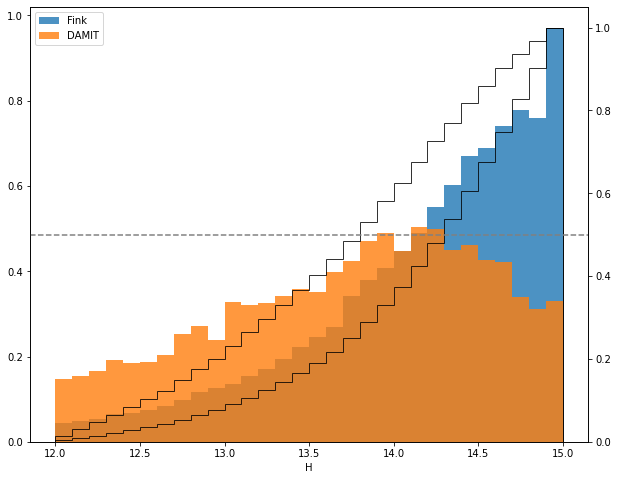

In [19]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(figsize=(10, 8))

r_H = [5, 20]
b_H = 30
r_H = [12, 15]

damit_file = os.path.join(data_fink, "data", "damit_abc.csv")
damit = pd.read_csv(damit_file)
damit = damit.merge(bft, left_on="number", right_on="sso_number", how="left")

ax2 = ax.twinx()

for x, l in zip(
    [data.loc[maskFINK, "absolute_magnitude.value"], damit["absolute_magnitude.value"]],
    ["Fink", "DAMIT"],
):
    ax.hist(x, range=r_H, bins=b_H, density=True, alpha=0.8, label=l)

    ax2.hist(
        x,
        range=r_H,
        bins=b_H,
        density=True,
        cumulative=True,
        histtype="step",
        alpha=0.8,
        label=l,
        color="black",
    )

    print(l, np.nanmedian(x))

ax2.axhline(0.5, color="grey", linestyle="dashed")

# delta Hmag = 0.5
p_damit = 13.65
p_fink = 14.78
pv = 0.15
print( (1329/np.sqrt(pv))*10**(-0.2*p_damit), (1329/np.sqrt(pv))*10**(-0.2*p_fink) )


ax.set_xlabel("H")
ax.legend(loc="upper left")

# Spin distribution

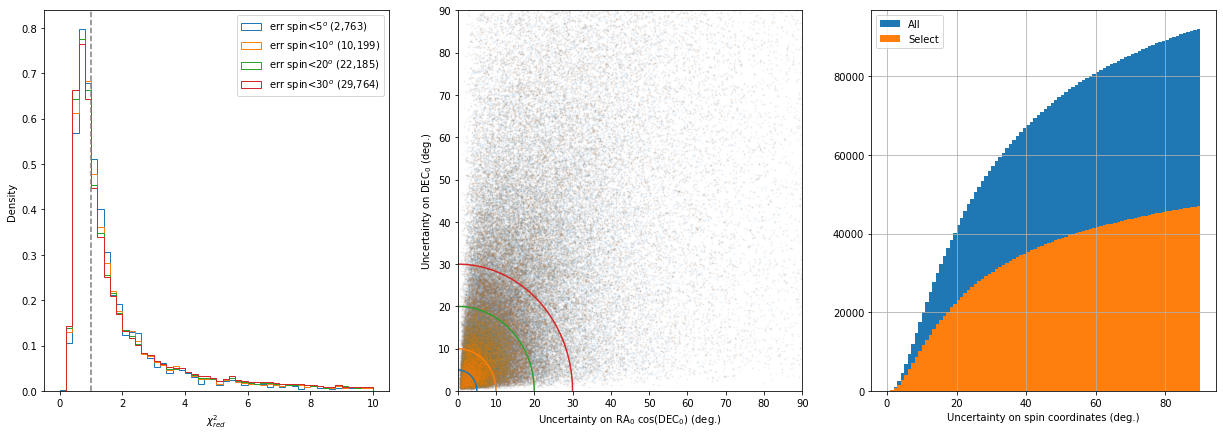

In [21]:
maskFINK = maskFINK_inter

fig, ax = plt.subplots(1, 3, figsize=(21, 7))


# Histogram of chi2
for err in [5, 10, 20, 30]:
    cond = maskFINK
    cond = cond * (data.SHG1G2_dSpin <= err)
    ax[0].hist(
        data.loc[cond, "SHG1G2_chi2red"],
        bins=50,
        histtype="step",
        density=True,
        range=[0, 10],
        label=f"err spin<{err:d}$^o$ ({len(data[cond]):,d})",
    )

    theta = np.linspace(0, np.pi / 2, num=90)
    ax[1].plot(err * np.cos(theta), err * np.sin(theta))

ax[0].axvline(1, ls="--", color="grey")
ax[0].set_xlabel(r"$\chi^2_{red}$")
ax[0].set_ylabel("Density")
ax[0].legend()


# Scatter dRA dDEC
ax[1].scatter(
    data.SHG1G2_dalpha0 * np.cos(np.radians(data["SHG1G2_delta0"])),
    data.SHG1G2_ddelta0,
    s=1,
    alpha=0.05,
)
ax[1].scatter(
    data.loc[maskFINK, "SHG1G2_dalpha0"]
    * np.cos(np.radians(data.loc[maskFINK, "SHG1G2_delta0"])),
    data.loc[maskFINK, "SHG1G2_ddelta0"],
    s=1,
    alpha=0.05,
)
ax[1].set_xlim(0, 90)
ax[1].set_ylim(0, 90)

ax[1].set_xlabel("Uncertainty on RA$_0$ cos(DEC$_0$) (deg.)")
ax[1].set_ylabel("Uncertainty on DEC$_0$ (deg.)")

# Cumulative dSpin
r = [0, 90]
b = 90
ax[2].hist(
    data.SHG1G2_dSpin, cumulative=True, density=False, range=r, bins=b, label="All"
)
ax[2].hist(
    data.loc[maskFINK, "SHG1G2_dSpin"],
    cumulative=True,
    density=False,
    range=r,
    bins=b,
    label="Select",
)

ax[2].grid()
ax[2].set_xlabel("Uncertainty on spin coordinates (deg.)")
ax[2].legend(loc="upper left")

# fig.savefig(f'{data_fink}plots/uncertainties_spin.png', facecolor='white', dpi=150)

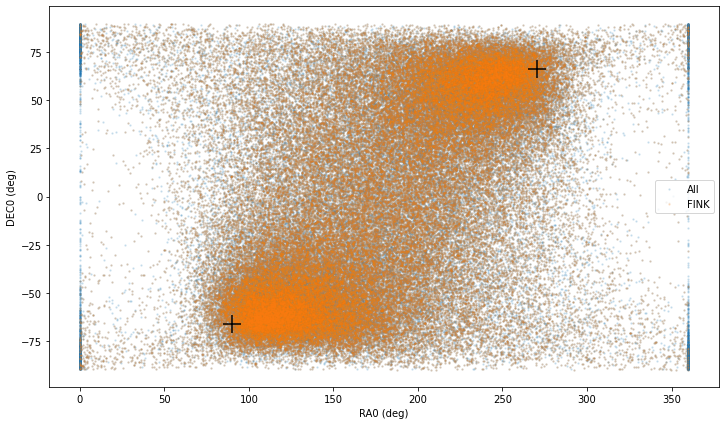

In [22]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(figsize=(12, 7))

xax = "SHG1G2_alpha0"
yax = "SHG1G2_delta0"

# All
cond = data.ssnamenr == data.ssnamenr
ax.scatter(data.loc[cond, xax], data.loc[cond, yax], s=2, alpha=0.15, label="All")

# FINK sample
cond = maskFINK
ax.scatter(data.loc[cond, xax], data.loc[cond, yax], s=2, alpha=0.15, label="FINK")


# Ecliptic poles
coords = SkyCoord(
    lon=0.1 * u.degree,
    lat=89.9 * u.degree,
    distance=200 * u.parsec,
    frame="heliocentricmeanecliptic",
)
ax.scatter(
    coords.hcrs.ra.value, coords.hcrs.dec.value, marker="+", s=300, color="black"
)

coords = SkyCoord(
    lon=0.1 * u.degree,
    lat=-89.9 * u.degree,
    distance=200 * u.parsec,
    frame="heliocentricmeanecliptic",
)
ax.scatter(
    coords.hcrs.ra.value, coords.hcrs.dec.value, marker="+", s=300, color="black"
)


ax.set_xlabel("RA0 (deg)")
ax.set_ylabel("DEC0 (deg)")
ax.legend()

fig.savefig(os.path.join(data_fink, "gfx", "models", "sky_bulk.png"), facecolor="white")

- There are a few weird solution at RA0=0 or RA0=360 
- We need to flip RA/DEC of half the solution

Text(0.5, 0, 'DEC_0')

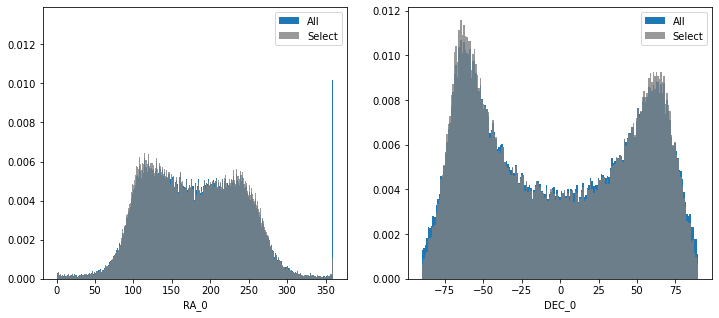

In [23]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(data.SHG1G2_alpha0, range=[0, 360], bins=361, density=True, label="All")
ax[0].hist(
    data.loc[maskFINK, "SHG1G2_alpha0"],
    range=[0, 360],
    bins=361,
    density=True,
    label="Select",
    color="grey",
    alpha=0.8,
)
ax[0].legend()
ax[0].set_xlabel("RA_0")

ax[1].hist(data.SHG1G2_delta0, range=[-90, 90], bins=181, density=True, label="All")
ax[1].hist(
    data.loc[maskFINK, "SHG1G2_delta0"],
    range=[-90, 90],
    bins=181,
    density=True,
    label="Select",
    color="grey",
    alpha=0.8,
)
ax[1].legend()
ax[1].set_xlabel("DEC_0")

In [24]:
# Flip half of the solution
cond = data.index % 2 == 0
xax = "SHG1G2_alpha0"
yax = "SHG1G2_delta0"

data.loc[cond, xax] = (data.loc[cond, xax] + 180) % 360
data.loc[cond, yax] = -data.loc[cond, yax]

# Convert to EC
coords = SkyCoord(
    ra=data.loc[cond, xax].values * u.deg,
    dec=data.loc[cond, yax].values * u.deg,
    distance=200 * u.parsec,
    frame="hcrs",
)
data.loc[cond, "lon"] = coords.heliocentricmeanecliptic.lon.value
data.loc[cond, "lat"] = coords.heliocentricmeanecliptic.lat.value

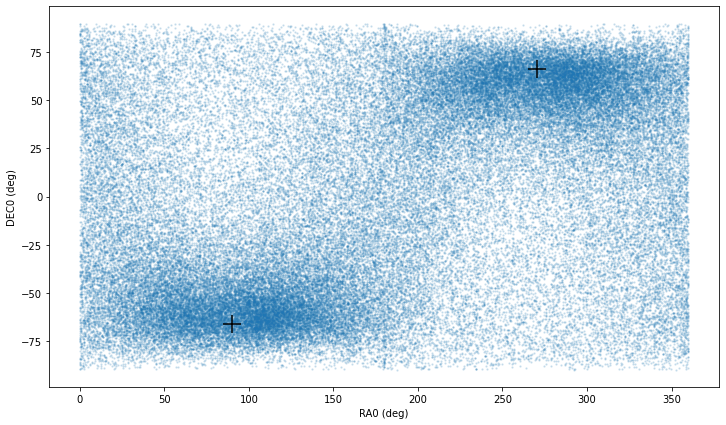

In [25]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(figsize=(12, 7))

xax = "SHG1G2_alpha0"
yax = "SHG1G2_delta0"

# Sample FINK
ax.scatter(data.loc[maskFINK, xax], data.loc[maskFINK, yax], s=2, alpha=0.15)

# Ecliptic poles
coords = SkyCoord(
    lon=0.1 * u.degree,
    lat=89.9 * u.degree,
    distance=200 * u.parsec,
    frame="heliocentricmeanecliptic",
)
ax.scatter(
    coords.hcrs.ra.value, coords.hcrs.dec.value, marker="+", s=300, color="black"
)
coords = SkyCoord(
    lon=0.1 * u.degree,
    lat=-89.9 * u.degree,
    distance=200 * u.parsec,
    frame="heliocentricmeanecliptic",
)
ax.scatter(
    coords.hcrs.ra.value, coords.hcrs.dec.value, marker="+", s=300, color="black"
)


ax.set_xlabel("RA0 (deg)")
ax.set_ylabel("DEC0 (deg)")

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "sky_selected.png"), facecolor="white"
)

# Compare with literature

In [26]:
data["spins.1.technique"].value_counts()

LC        15850
LCI        9908
LC+TPM      570
TE           50
ADAM         45
LC-TPM       40
Radar        18
LC+Occ       18
SPACE         6
A-M           5
SAGE          4
LC+IM         4
Bin-IM        1
TE-Occ        1
Name: spins.1.technique, dtype: int64

In [27]:
# Compute angular distances
spin_version = np.array(["A", "B"])

for ks in ["1", "2", "3", "4"]:
    data[f"spins.{ks}.distance"] = np.nan
    cond = ~data[f"spins.{ks}.RA0.value"].isna()

    # ------------------------------------------------------------------------------------------
    # A: Original spins
    data.loc[cond, f"spins.{ks}.distance.A"] = data.loc[
        cond,
        [
            f"spins.{ks}.RA0.value",
            f"spins.{ks}.DEC0.value",
            "SHG1G2_alpha0",
            "SHG1G2_delta0",
        ],
    ].apply(
        lambda x: np.degrees(
            angular_separation(
                np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3])
            )
        ),
        axis=1,
    )
    data.loc[cond, f"spins.{ks}.delta_RA.A"] = (
        data.loc[cond, f"spins.{ks}.RA0.value"] - data.loc[cond, "SHG1G2_alpha0"]
    ) * np.cos(np.radians(data.loc[cond, f"spins.{ks}.DEC0.value"]))
    data.loc[cond, f"spins.{ks}.delta_DEC.A"] = (
        data.loc[cond, f"spins.{ks}.DEC0.value"] - data.loc[cond, "SHG1G2_delta0"]
    )
    data.loc[cond, f"spins.{ks}.RA.A"] = data.loc[cond, f"spins.{ks}.RA0.value"]
    data.loc[cond, f"spins.{ks}.DEC.A"] = data.loc[cond, f"spins.{ks}.DEC0.value"]

    # ------------------------------------------------------------------------------------------
    # B: RA-180 & Flip DEC
    data.loc[cond, f"spins.{ks}.distance.B"] = data.loc[
        cond,
        [
            f"spins.{ks}.RA0.value",
            f"spins.{ks}.DEC0.value",
            "SHG1G2_alpha0",
            "SHG1G2_delta0",
        ],
    ].apply(
        lambda x: np.degrees(
            angular_separation(
                np.radians((x[0] + 180) % 360),
                np.radians(-x[1]),
                np.radians(x[2]),
                np.radians(x[3]),
            )
        ),
        axis=1,
    )
    data.loc[cond, f"spins.{ks}.delta_RA.B"] = (
        ((data.loc[cond, f"spins.{ks}.RA0.value"] + 180.0) % 360)
        - data.loc[cond, "SHG1G2_alpha0"]
    ) * np.cos(np.radians(-data.loc[cond, f"spins.{ks}.DEC0.value"]))
    data.loc[cond, f"spins.{ks}.delta_DEC.B"] = (
        -data.loc[cond, f"spins.{ks}.DEC0.value"] - data.loc[cond, "SHG1G2_delta0"]
    )
    data.loc[cond, f"spins.{ks}.RA.B"] = (
        data.loc[cond, f"spins.{ks}.RA0.value"] + 180.0
    ) % 360
    data.loc[cond, f"spins.{ks}.DEC.B"] = -data.loc[cond, f"spins.{ks}.DEC0.value"]

    # ------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond, f"spins.{ks}.closest"] = data.loc[
        cond, [f"spins.{ks}.distance.A", f"spins.{ks}.distance.B"]
    ].apply(lambda x: int(np.argmin(x)), axis=1)
    data = data.astype({f"spins.{ks}.closest": "Int64"})

    data.loc[cond, f"spins.{ks}.distance"] = data.loc[
        cond, [f"spins.{ks}.distance.A", f"spins.{ks}.distance.B"]
    ].apply(lambda x: np.min(x), axis=1)
    data.loc[cond, f"spins.{ks}.version"] = data.loc[
        cond, [f"spins.{ks}.distance.A", f"spins.{ks}.distance.B"]
    ].apply(lambda x: spin_version[np.argmin(x)], axis=1)

    # ------------------------------------------------------------------------------------------
    # Find minimum distance and keep track of which spin version it is
    data.loc[cond, f"spins.{ks}.delta_RA"] = data.loc[
        cond,
        [f"spins.{ks}.delta_RA.A", f"spins.{ks}.delta_RA.B", f"spins.{ks}.closest"],
    ].apply(lambda x: x[int(x[2])], axis=1)
    data.loc[cond, f"spins.{ks}.delta_DEC"] = data.loc[
        cond,
        [f"spins.{ks}.delta_DEC.A", f"spins.{ks}.delta_DEC.B", f"spins.{ks}.closest"],
    ].apply(lambda x: x[int(x[2])], axis=1)
    data.loc[cond, f"spins.{ks}.RA"] = data.loc[
        cond, [f"spins.{ks}.RA.A", f"spins.{ks}.RA.B", f"spins.{ks}.closest"]
    ].apply(lambda x: x[int(x[2])], axis=1)
    data.loc[cond, f"spins.{ks}.DEC"] = data.loc[
        cond, [f"spins.{ks}.RA.A", f"spins.{ks}.RA.B", f"spins.{ks}.closest"]
    ].apply(lambda x: x[int(x[2])], axis=1)


# Select the closest angularly
cond = ~data[f"spins.1.distance"].isna()
data.loc[cond, "spins.closest"] = data.loc[
    cond,
    ["spins.1.distance", "spins.2.distance", "spins.3.distance", "spins.4.distance"],
].apply(lambda x: int(np.argmin(x)), axis=1)
data = data.astype({"spins.closest": "Int64"})

data.loc[cond, "spins.distance"] = data.loc[
    cond,
    ["spins.1.distance", "spins.2.distance", "spins.3.distance", "spins.4.distance"],
].apply(lambda x: np.min(x), axis=1)
data.loc[cond, "spins.delta_RA"] = data.loc[
    cond,
    [
        f"spins.1.delta_RA",
        f"spins.2.delta_RA",
        f"spins.3.delta_RA",
        f"spins.4.delta_RA",
        f"spins.closest",
    ],
].apply(lambda x: x[int(x[4])], axis=1)
data.loc[cond, "spins.delta_DEC"] = data.loc[
    cond,
    [
        f"spins.1.delta_DEC",
        f"spins.2.delta_DEC",
        f"spins.3.delta_DEC",
        f"spins.4.delta_DEC",
        f"spins.closest",
    ],
].apply(lambda x: x[int(x[4])], axis=1)

data.loc[cond, "spins.err_RA"] = data.loc[
    cond,
    [
        f"spins.1.RA0.error.max",
        f"spins.2.RA0.error.max",
        f"spins.3.RA0.error.max",
        f"spins.4.RA0.error.max",
        f"spins.closest",
    ],
].apply(lambda x: x[int(x[4])], axis=1)
data.loc[cond, "spins.err_DEC"] = data.loc[
    cond,
    [
        f"spins.1.DEC0.error.max",
        f"spins.2.DEC0.error.max",
        f"spins.3.DEC0.error.max",
        f"spins.4.DEC0.error.max",
        f"spins.closest",
    ],
].apply(lambda x: x[int(x[4])], axis=1)

data.loc[cond, "spins.RA"] = data.loc[
    cond, [f"spins.1.RA", f"spins.2.RA", f"spins.3.RA", f"spins.4.RA", f"spins.closest"]
].apply(lambda x: x[int(x[4])], axis=1)
data.loc[cond, "spins.DEC"] = data.loc[
    cond,
    [f"spins.1.DEC", f"spins.2.DEC", f"spins.3.DEC", f"spins.4.DEC", f"spins.closest"],
].apply(lambda x: x[int(x[4])], axis=1)

In [28]:
for c in ["spins.RA", "spins.DEC", "spins.err_RA", "spins.err_DEC"]:
    missing = data[c].isna()
    data.loc[missing, c] = 15.0

In [29]:
for c in ["spins.RA", "spins.DEC", "spins.err_RA", "spins.err_DEC"]:
    missing = data[c].isna()
    print(c, len(data[missing]))
    data[c] = data[c].astype(float)
len(data)

spins.RA 0
spins.DEC 0
spins.err_RA 0
spins.err_DEC 0


122675

In [30]:
data.loc[cond, "spins.dSpin"] = np.sqrt(
    (data.loc[cond, "spins.err_RA"] * np.cos(np.radians(data.loc[cond, "spins.DEC"])))
    ** 2
    + data.loc[cond, "spins.err_DEC"] ** 2
)

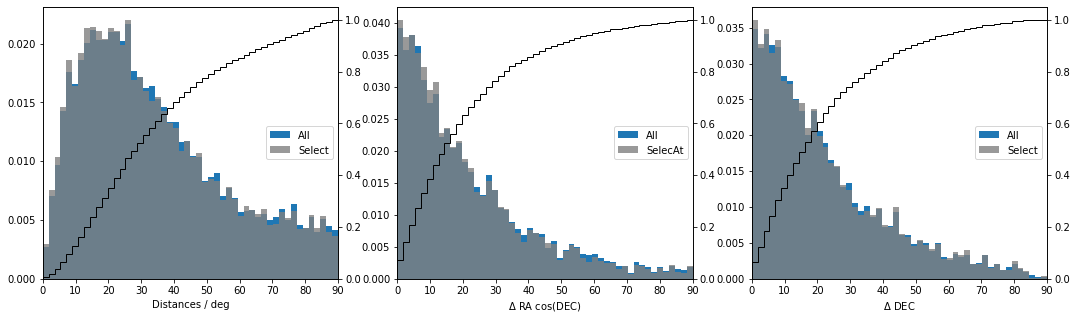

In [31]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

cond = data.ssnamenr == data.ssnamenr

r = [0, 90]
b = 50
ax[0].hist(data.loc[cond, "spins.distance"], range=r, bins=b, density=True, label="All")
ax[0].hist(
    data.loc[maskFINK, "spins.distance"],
    range=r,
    bins=b,
    density=True,
    label="Select",
    color="grey",
    alpha=0.8,
)
ax[0].legend(loc="center right")
ax[0].set_xlabel("Distances / deg")
ax0 = ax[0].twinx()
ax0.hist(
    data.loc[maskFINK, "spins.distance"],
    range=r,
    bins=b,
    density=True,
    cumulative=True,
    histtype="step",
    color="black",
)
ax[0].set_xlim(r)

ax[1].hist(data.loc[cond, "spins.delta_RA"], range=r, bins=b, density=True, label="All")
ax[1].hist(
    data.loc[maskFINK, "spins.delta_RA"],
    range=r,
    bins=b,
    density=True,
    label="SelecAt",
    color="grey",
    alpha=0.8,
)
ax[1].legend(loc="center right")
ax[1].set_xlabel("$\Delta$ RA cos(DEC)")
ax1 = ax[1].twinx()
ax1.hist(
    data.loc[maskFINK, "spins.delta_RA"],
    range=r,
    bins=b,
    density=True,
    cumulative=True,
    histtype="step",
    color="black",
)
ax[1].set_xlim(r)

ax[2].hist(
    data.loc[cond, "spins.delta_DEC"], range=r, bins=b, density=True, label="All"
)
ax[2].hist(
    data.loc[maskFINK, "spins.delta_DEC"],
    range=r,
    bins=b,
    density=True,
    label="Select",
    color="grey",
    alpha=0.8,
)
ax[2].legend(loc="center right")
ax[2].set_xlabel("$\Delta$ DEC")
ax2 = ax[2].twinx()
ax2.hist(
    data.loc[maskFINK, "spins.delta_DEC"],
    range=r,
    bins=b,
    density=True,
    cumulative=True,
    histtype="step",
    color="black",
)
ax[2].set_xlim(r)

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "sky_distances.png"), facecolor="white"
)

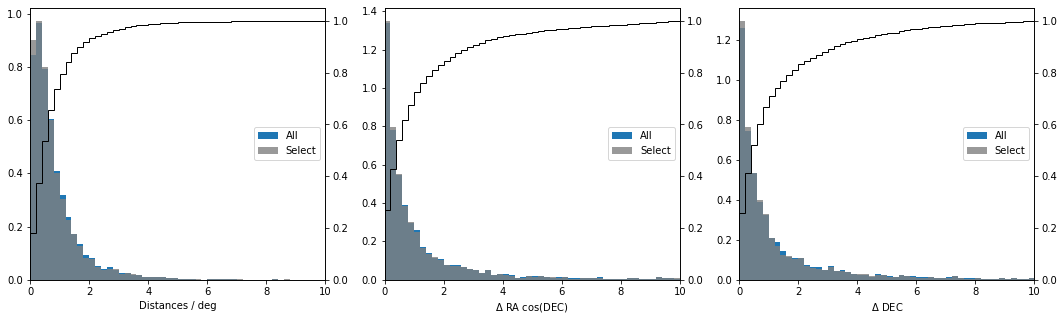

In [32]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(1, 3, figsize=(18, 5))


r = [0, 10]
b = 50

x = data["spins.distance"] / np.sqrt(
    data["SHG1G2_dSpin"] ** 2 + data["spins.dSpin"] ** 2
)
ax[0].hist(x, range=r, bins=b, density=True, label="All")
ax[0].hist(
    x[maskFINK], range=r, bins=b, density=True, label="Select", color="grey", alpha=0.8
)
ax[0].legend(loc="center right")
ax[0].set_xlabel("Distances / deg")
ax0 = ax[0].twinx()
ax0.hist(
    x[maskFINK],
    range=r,
    bins=b,
    density=True,
    cumulative=True,
    histtype="step",
    color="black",
)
ax[0].set_xlim(r)

x = data["spins.delta_RA"] / data["SHG1G2_dalpha0"]
ax[1].hist(x, range=r, bins=b, density=True, label="All")
ax[1].hist(
    x[maskFINK], range=r, bins=b, density=True, label="Select", color="grey", alpha=0.8
)
ax[1].legend(loc="center right")
ax[1].set_xlabel("$\Delta$ RA cos(DEC)")
ax1 = ax[1].twinx()
ax1.hist(
    x[maskFINK],
    range=r,
    bins=b,
    density=True,
    cumulative=True,
    histtype="step",
    color="black",
)
ax[1].set_xlim(r)

x = data["spins.delta_DEC"] / data["SHG1G2_ddelta0"]
ax[2].hist(x, range=r, bins=b, density=True, label="All")
ax[2].hist(
    x[maskFINK], range=r, bins=b, density=True, label="Select", color="grey", alpha=0.8
)
ax[2].legend(loc="center right")
ax[2].set_xlabel("$\Delta$ DEC")
ax2 = ax[2].twinx()
ax2.hist(
    x[maskFINK],
    range=r,
    bins=b,
    density=True,
    cumulative=True,
    histtype="step",
    color="black",
)
ax[2].set_xlim(r)

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "sky_distances_normed.png"),
    facecolor="white",
)

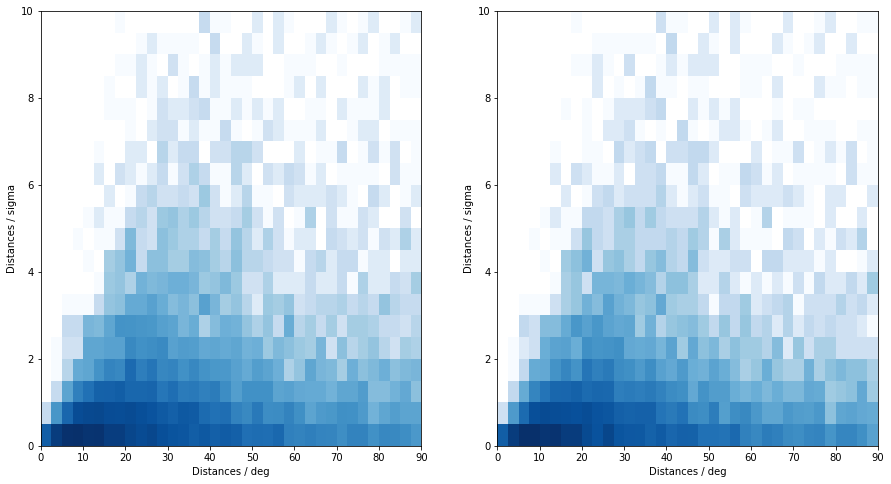

In [33]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

r = [[0, 90], [0, 10]]
b = [36, 20]

x = data["spins.distance"]
y = data["spins.distance"] / data["SHG1G2_dSpin"]
ax[0].hist2d(x, y, label="All", range=r, bins=b, cmap="Blues", norm="log", density=True)
ax[1].hist2d(
    x[maskFINK],
    y[maskFINK],
    label="Select",
    range=r,
    bins=b,
    cmap="Blues",
    norm="log",
    density=True,
)

# ax[0].legend(loc='center right')
for a in ax:
    a.set_xlabel("Distances / deg")
    a.set_ylabel("Distances / sigma")

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "sky_distances_vs_sigma.png"),
    facecolor="white",
)

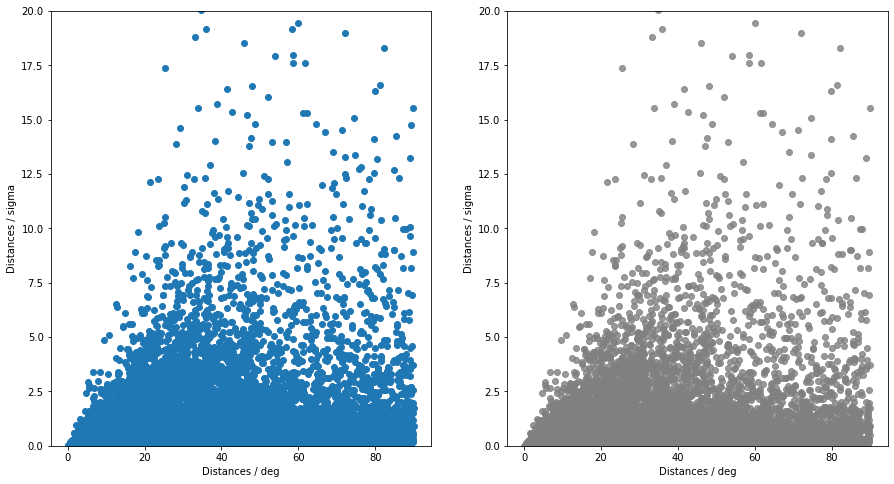

In [34]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

r = [[0, 90], [0, 20]]
# b = [90,50]

x = data["spins.distance"]  # / data['SHG1G2_dSpin']
y = data["spins.distance"] / data["SHG1G2_dSpin"]
ax[0].scatter(x, y, label="All")
ax[1].scatter(x[maskFINK], y[maskFINK], label="Select", color="grey", alpha=0.8)

# ax[0].legend(loc='center right')
for a in ax:
    a.set_xlabel("Distances / deg")
    a.set_ylabel("Distances / sigma")
    a.set_ylim(r[1])

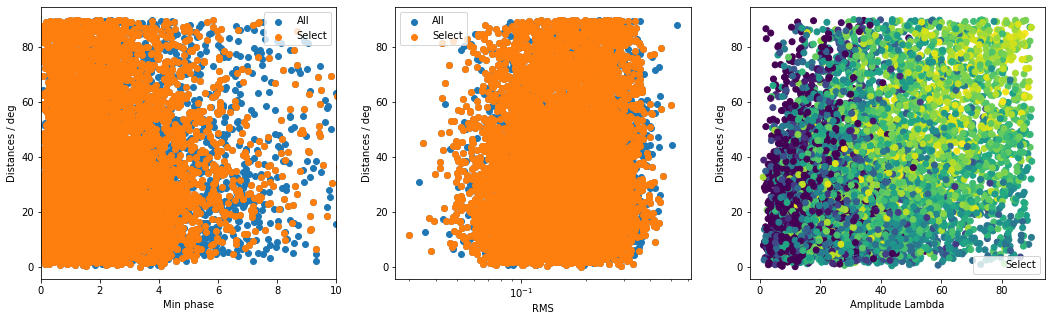

In [35]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

x = data["min_phase"]
y = data["spins.distance"]
ax[0].scatter(x, y, label="All")
ax[0].scatter(x[maskFINK], y[maskFINK], label="Select")
ax[0].legend()
ax[0].set_xlabel("Min phase")
ax[0].set_ylabel("Distances / deg")
ax[0].set_xlim(0, 10)

x = data["SHG1G2_rms"]
y = data["spins.distance"]
ax[1].scatter(x, y, label="All")
ax[1].scatter(x[maskFINK], y[maskFINK], label="Select")
ax[1].legend()
ax[1].set_xlabel("RMS")
ax[1].set_xscale("log")
ax[1].set_ylabel("Distances / deg")

# x = np.degrees(np.arccos(data['SHG1G2_maxCosLambda'] - data['SHG1G2_minCosLambda']))
x = np.degrees(
    np.arccos(data["SHG1G2_min_cos_lambda"]) - np.arccos(data["SHG1G2_max_cos_lambda"])
)
y = data["spins.distance"]
# ax[2].scatter( x, y, label='All' )
ax[2].scatter(
    x[maskFINK], y[maskFINK], c=data.loc[maskFINK, "SHG1G2_R"], label="Select"
)
ax[2].legend()
ax[2].set_xlabel("Amplitude Lambda")
# ax[2].set_yscale('log')
ax[2].set_ylabel("Distances / deg")

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "sky_distances_vs_obs.png"),
    facecolor="white",
)

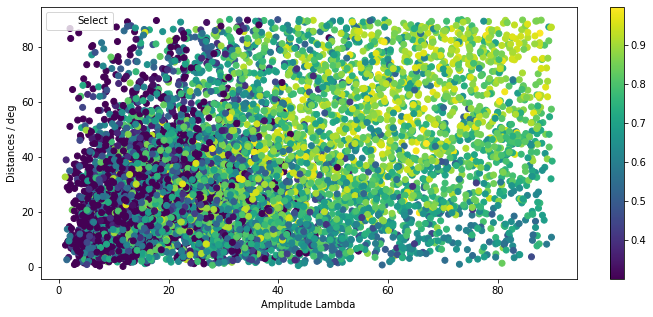

In [36]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(figsize=(12, 5))

x = np.degrees(
    np.arccos(data["SHG1G2_min_cos_lambda"]) - np.arccos(data["SHG1G2_max_cos_lambda"])
)
y = data["spins.distance"]
im = ax.scatter(
    x[maskFINK], y[maskFINK], c=data.loc[maskFINK, "SHG1G2_R"], label="Select"
)
ax.legend()
ax.set_xlabel("Amplitude Lambda")
ax.set_ylabel("Distances / deg")

fig.colorbar(im)

# fig.savefig( os.path.join(data_fink, 'gfx', 'valid', 'sky_distances_vs_obs.png'), facecolor='white')

Text(0, 0.5, 'Distances / deg')

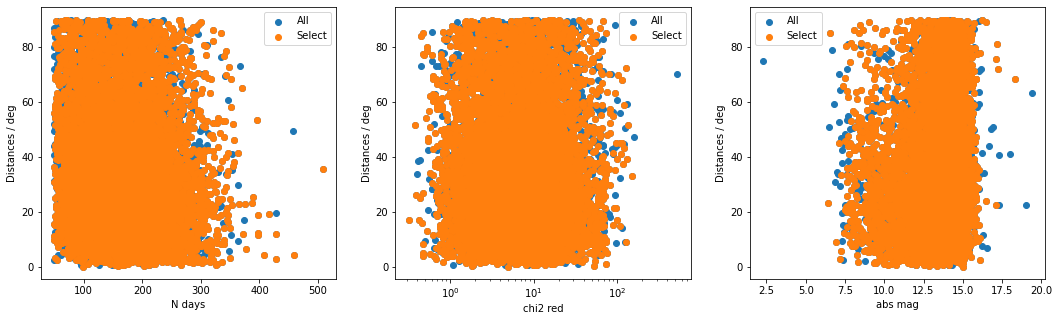

In [37]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

cond = data.ssnamenr == data.ssnamenr

ax[0].scatter(data.loc[cond, "n_days"], data.loc[cond, "spins.distance"], label="All")
ax[0].scatter(
    data.loc[maskFINK, "n_days"], data.loc[maskFINK, "spins.distance"], label="Select"
)
ax[0].legend()
ax[0].set_xlabel("N days")
ax[0].set_ylabel("Distances / deg")

ax[1].scatter(
    data.loc[cond, "SHG1G2_chi2red"], data.loc[cond, "spins.distance"], label="All"
)
ax[1].scatter(
    data.loc[maskFINK, "SHG1G2_chi2red"],
    data.loc[maskFINK, "spins.distance"],
    label="Select",
)
ax[1].legend()
ax[1].set_xlabel("chi2 red")
ax[1].set_xscale("log")
ax[1].set_ylabel("Distances / deg")

ax[2].scatter(
    data.loc[cond, "absolute_magnitude.value"],
    data.loc[cond, "spins.distance"],
    label="All",
)
ax[2].scatter(
    data.loc[maskFINK, "absolute_magnitude.value"],
    data.loc[maskFINK, "spins.distance"],
    label="Select",
)
ax[2].legend()
ax[2].set_xlabel("abs mag")
# ax[2].set_xscale('log')
ax[2].set_ylabel("Distances / deg")

(95593, 10256)

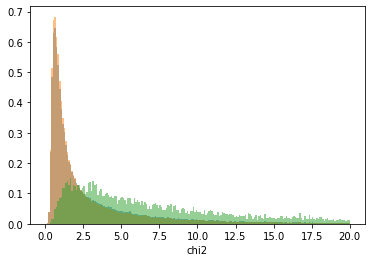

In [38]:
maskFINK = maskFINK_union

r = [0, 20]
b = 200
plt.hist(data["SHG1G2_chi2red"], range=r, bins=b, alpha=0.5, density=True)
plt.hist(data.loc[maskFINK, "SHG1G2_chi2red"], range=r, bins=b, alpha=0.5, density=True)

cond = data["spins.1.RA0.value"].notna()
plt.hist(data.loc[cond, "SHG1G2_chi2red"], range=r, bins=b, alpha=0.5, density=True)
# plt.xlim(0,10)
plt.xlabel("chi2")

len(data[maskFINK]), len(data[cond])

- fishy: the object with spins have shitty chi2red!
- Explanation: there is bias for high amplitude for LC-derived spins -> bad for HG1G2hybrid (LC not taken into account)

(95593, 10256)

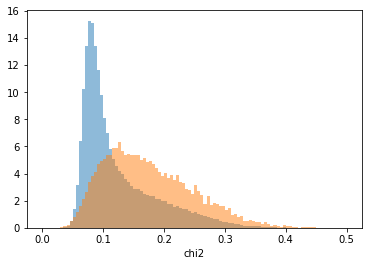

In [39]:
maskFINK = maskFINK_union

r = [0, 0.5]
b = 100
# plt.hist(data['SHG1G2_rms'], range=r, bins=b, alpha=0.5, density=True )
plt.hist(data.loc[maskFINK, "SHG1G2_rms"], range=r, bins=b, alpha=0.5, density=True)

cond = data["spins.1.RA0.value"].notna()
plt.hist(data.loc[cond, "SHG1G2_rms"], range=r, bins=b, alpha=0.5, density=True)
# plt.xlim(0,10)
plt.xlabel("chi2")

len(data[maskFINK]), len(data[cond])

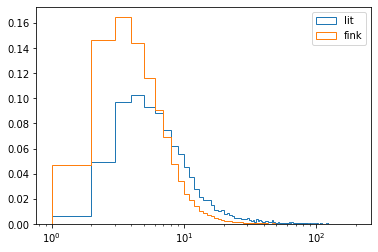

In [40]:
maskFINK = maskFINK_union

fig, ax = plt.subplots()

ax.hist(
    data.loc[cond, "diameter.value"],
    histtype="step",
    bins=np.linspace(1, 200, num=200),
    density=True,
    label="lit",
)
ax.hist(
    data.loc[maskFINK, "diameter.value"],
    histtype="step",
    bins=np.linspace(1, 200, num=200),
    density=True,
    label="fink",
)

ax.set_xscale("log")
ax.legend()

In [41]:
cond = maskFINK_union
lim_spin = 30
spin_v = "1"
cond = cond * (data[f"spins.{spin_v}.distance"] < lim_spin)
data.loc[cond, f"spins.{spin_v}.technique"].value_counts()

# plt.hist( data.loc[cond,'spins.1.distance'] )

LCI       3028
LC+TPM     158
LC          19
LC-TPM      14
ADAM        12
TE           4
Radar        4
LC+Occ       3
SPACE        2
LC+IM        1
A-M          1
Name: spins.1.technique, dtype: int64

In [42]:
cond = maskFINK_union
data[cond].sort_values(by="sso_number").head(20)

,ssnamenr,HG_chi2red,HG_status,HG_fit,HG_rms,HG_rms_g,HG_rms_r,HG_median_error_phot,HG_median_error_phot_1,HG_median_error_phot_2,...,spins.4.DEC,spins.closest,spins.distance,spins.delta_RA,spins.delta_DEC,spins.err_RA,spins.err_DEC,spins.RA,spins.DEC,spins.dSpin
48887,21,26.511726,2.0,0.0,0.102094,0.115203,0.078925,0.020901,0.020243,0.021333,...,NaN,0,68.778634,-26.696135,64.804379,0.400,0.400,51.800000,51.800000,0.470307
122580,24,4.138918,2.0,0.0,0.043204,0.039938,0.048306,0.022072,0.022072,0.021773,...,NaN,0,5.720167,-5.705446,-1.397980,3.667,2.576,246.135000,246.135000,2.972686
4783,26,13.722657,2.0,0.0,0.076438,0.082265,0.062702,0.021510,0.021399,0.022048,...,NaN,0,45.960181,6.135773,-45.489223,15.000,15.000,87.057356,87.057356,15.019753
30399,33,5.222711,2.0,0.0,0.055226,0.057039,0.053935,0.024150,0.023779,0.024330,...,NaN,0,45.525913,-22.240737,-36.054482,2.124,3.267,159.160000,159.160000,3.822785
66564,34,10.532562,2.0,0.0,0.075972,0.074007,0.077102,0.025044,0.025665,0.024766,...,NaN,0,40.718530,-3.108015,-40.664560,2.414,2.414,273.549000,273.549000,2.418621
76920,35,62.221203,2.0,0.0,0.166508,0.162629,0.170846,0.023033,0.023087,0.022921,...,NaN,0,51.956374,-305.346685,-36.412545,30.000,30.000,11.581000,11.581000,41.996766
31162,36,6.241411,2.0,0.0,0.049538,0.056127,0.041732,0.023337,0.022076,0.024839,...,NaN,0,49.095223,-122.837718,25.683317,5.000,5.000,157.458000,157.458000,6.806311
82025,37,15.606251,2.0,0.0,0.067412,0.073915,0.051666,0.019782,0.019637,0.021249,...,NaN,0,65.976614,5.254483,-65.850031,5.000,5.000,270.000000,270.000000,5.000000
42731,38,18.934998,2.0,0.0,0.092678,0.091143,0.094324,0.022102,0.021948,0.023030,...,NaN,1,11.371511,2.327920,11.123515,5.000,5.000,166.679000,166.679000,6.976591
56252,41,67.364067,4.0,0.0,0.160561,0.144075,0.185847,0.020439,0.020717,0.019814,...,NaN,0,12.197913,-12.083559,-1.059034,3.837,3.837,181.482000,181.482000,5.425430


In [43]:
cond = maskFINK_union
showcols = [
    "number",
    "name",  #'minphase','maxphase','n_days',
    "SHG1G2_alpha0",
    "SHG1G2_delta0",
    "spins.1.RA0.value",
    "spins.1.DEC0.value",
    "spins.1.version",
    "spins.2.RA0.value",
    "spins.2.DEC0.value",
    "spins.2.version",
    "spins.1.distance",
    "spins.2.distance",
]
data.loc[cond, showcols].sort_values(by="number").head(20)

,number,name,SHG1G2_alpha0,SHG1G2_delta0,spins.1.RA0.value,spins.1.DEC0.value,spins.1.version,spins.2.RA0.value,spins.2.DEC0.value,spins.2.version,spins.1.distance,spins.2.distance
48887,21,Lutetia,78.977524,-54.004379,51.800000,10.800000,A,NaN,NaN,NaN,68.778634,NaN
122580,24,Themis,259.394035,65.910980,246.135000,64.513000,A,NaN,NaN,NaN,5.720167,NaN
4783,26,Proserpina,80.308998,20.887651,87.057356,-24.601571,A,NaN,NaN,NaN,45.960181,NaN
30399,33,Polyhymnia,192.717560,-12.434518,159.160000,-48.489000,A,33.170,-41.402,B,45.525913,57.049331
66564,34,Circe,277.056816,68.286560,273.549000,27.622000,A,96.252,58.352,A,40.718530,53.360073
76920,35,Leukothea,325.824066,50.078545,11.581000,13.666000,A,195.126,-5.372,B,51.956374,60.763077
31162,36,Atalante,358.310318,-77.979317,157.458000,-52.296000,A,57.416,-30.524,A,49.095223,53.922594
82025,37,Fides,264.729706,61.410751,270.000000,-4.439279,A,NaN,NaN,NaN,65.976614,NaN
42731,38,Leda,164.297165,1.090485,155.139000,-7.940000,A,346.679,-12.214,B,12.843157,11.371511
56252,41,Daphne,196.396381,-34.825966,181.482000,-35.885000,A,NaN,NaN,NaN,12.197913,NaN


In [44]:
data.columns[:80]

Index(['ssnamenr', 'HG_chi2red', 'HG_status', 'HG_fit', 'HG_rms', 'HG_rms_g',
       'HG_rms_r', 'HG_median_error_phot', 'HG_median_error_phot_1',
       'HG_median_error_phot_2', 'HG_H_g', 'HG_dH_g', 'HG_G_g', 'HG_dG_g',
       'HG_H_r', 'HG_dH_r', 'HG_G_r', 'HG_dG_r', 'HG_flag', 'HG1G2_chi2red',
       'HG1G2_status', 'HG1G2_fit', 'HG1G2_rms', 'HG1G2_rms_g', 'HG1G2_rms_r',
       'HG1G2_median_error_phot', 'HG1G2_median_error_phot_1',
       'HG1G2_median_error_phot_2', 'HG1G2_H_g', 'HG1G2_dH_g', 'HG1G2_G1_g',
       'HG1G2_dG1_g', 'HG1G2_G2_g', 'HG1G2_dG2_g', 'HG1G2_H_r', 'HG1G2_dH_r',
       'HG1G2_G1_r', 'HG1G2_dG1_r', 'HG1G2_G2_r', 'HG1G2_dG2_r', 'HG1G2_flag',
       'SHG1G2_chi2red', 'SHG1G2_min_cos_lambda', 'SHG1G2_mean_cos_lambda',
       'SHG1G2_max_cos_lambda', 'SHG1G2_status', 'SHG1G2_fit', 'SHG1G2_rms',
       'SHG1G2_rms_g', 'SHG1G2_rms_r', 'SHG1G2_median_error_phot',
       'SHG1G2_median_error_phot_1', 'SHG1G2_median_error_phot_2', 'n_obs',
       'n_obs_g', 'n_obs_r', 

# Obliquity

In [45]:
# Obliquity of the spin
data["lon_orbit"] = data["orbital_elements.node_longitude.value"] - 90
data["lat_orbit"] = 90.0 - data["orbital_elements.inclination.value"]
data["obliquity"] = data[["lon", "lat", "lon_orbit", "lat_orbit"]].apply(
    lambda x: np.degrees(
        angular_separation(
            np.radians(x[0]), np.radians(x[1]), np.radians(x[2]), np.radians(x[3])
        )
    ),
    axis=1,
)

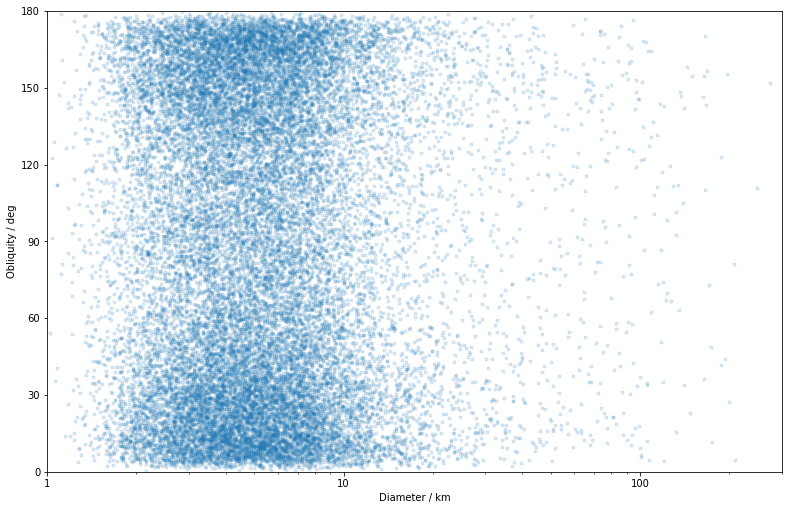

In [46]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(
    figsize=(12, 8), gridspec_kw={"right": 0.975, "top": 0.95, "bottom": 0.15}
)

cond = data.ssnamenr == data.ssnamenr
cond = maskFINK
ax.scatter(
    data.loc[cond, "diameter.value"],
    data.loc[cond, "obliquity"],
    marker=".",
    # color=colors[0],
    # s=2,
    alpha=0.15,
)

ax.set_xscale("log")
ax.set_xlim(1, 300)
ax.set_ylim(0, 180)
ax.set_xlabel("Diameter / km")
ax.set_ylabel("Obliquity / deg")


ax.set_xticks([1, 10, 100])
ax.set_xticklabels(["1", "10", "100"])
ax.set_yticks([0, 30, 60, 90, 120, 150, 180])

fig.savefig(
    os.path.join(data_fink, "gfx", "models", "obliquity_vs_diameter.png"),
    facecolor="white",
)

(array([ 402., 1122., 1208., 1025.,  944.,  951.,  866.,  729.,  624.,
         613.,  533.,  487.,  470.,  403.,  379.,  395.,  399.,  427.,
         404.,  415.,  433.,  396.,  353.,  472.,  435.,  434.,  480.,
         594.,  618.,  651.,  782.,  789.,  852.,  945., 1057.,  941.,
         329.]),
 array([  0.        ,   4.86486486,   9.72972973,  14.59459459,
         19.45945946,  24.32432432,  29.18918919,  34.05405405,
         38.91891892,  43.78378378,  48.64864865,  53.51351351,
         58.37837838,  63.24324324,  68.10810811,  72.97297297,
         77.83783784,  82.7027027 ,  87.56756757,  92.43243243,
         97.2972973 , 102.16216216, 107.02702703, 111.89189189,
        116.75675676, 121.62162162, 126.48648649, 131.35135135,
        136.21621622, 141.08108108, 145.94594595, 150.81081081,
        155.67567568, 160.54054054, 165.40540541, 170.27027027,
        175.13513514, 180.        ]),
 <BarContainer object of 37 artists>)

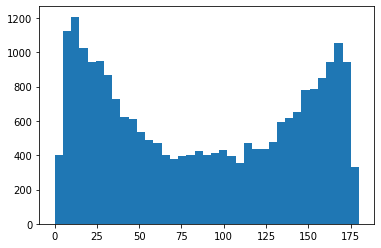

In [48]:
cond = maskFINK_union & (data["diameter.value"] < 10)
fig, ax = plt.subplots()

r = [0, 180]
b = 37
ax.hist(data.loc[cond, "obliquity"], bins=b, range=r)

In [49]:
np.sqrt(2 * np.pi / (5 * 3600)), np.sqrt(2 * np.pi / (5 * 365.24 * 86400))

(0.01868330405465976, 0.00019955329064394955)

In [50]:
nu = [1e-8, 1e-4]

ti = 200
emissivity = 0.9
sigma_b = 5.670374419e-8
S_sun = 1360
beaming = 0.9
delta = 3.0
pV = 0.15
A = (0.29 + 0.684 * 0.15) * pV

theta = (
    ti
    * np.sqrt(nu)
    * ((beaming * delta**2) ** (3 / 4))
    * ((sigma_b * emissivity) ** (-1 / 4))
    * (((1 - A) * S_sun) ** (-3 / 4))
)

W = -0.5 * theta / (1 + theta + 0.5 * theta**2)

Wn = W[0]
Ww = W[1]

print(W)

[-0.01448942 -0.17681723]


In [53]:
data.loc[maskFINK_union, "family.family_name"].value_counts().head(30)

Vesta         4183
Eos           2839
Hertha        2223
Koronis       1882
Themis        1409
Maria         1232
Astraea        999
Eulalia        985
Eunomia        956
Phocaea        904
Hygiea         902
Baptistina     807
Hungaria       783
Minerva        760
Iduna          729
Adeona         505
Mnemosyne      496
Flora          459
Massalia       445
Euphrosyne     375
Dora           358
Levin          348
Hansa          285
Tirela         282
Veritas        272
Erigone        252
Eurynome       239
Rafita         235
Agnia          234
Merxia         178
Name: family.family_name, dtype: int64

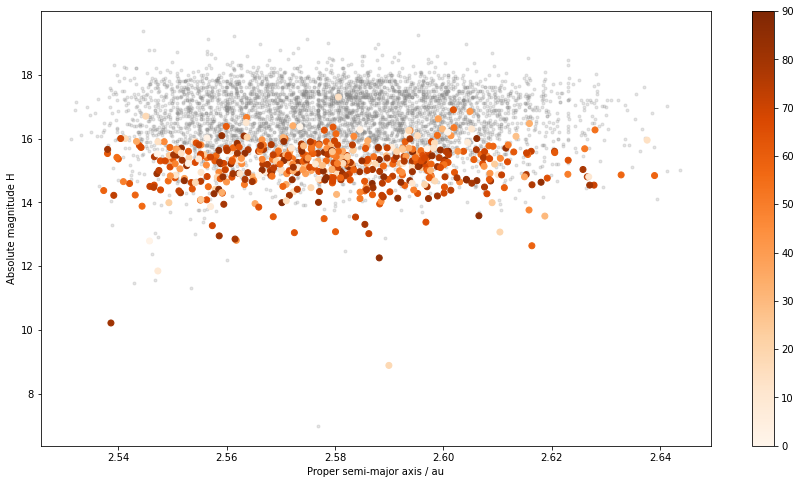

In [55]:
maskFINK = maskFINK_union

fig, ax = plt.subplots(figsize=(15, 8))

f = "Astraea"

cond = bft["family.family_name"] == f
ax.scatter(
    bft.loc[cond, "proper_elements.proper_semi_major_axis.value"],
    bft.loc[cond, "absolute_magnitude.value"],
    color="grey",
    alpha=0.2,
    marker=".",
)


cond = maskFINK & (data["family.family_name"] == f)
im = ax.scatter(
    data.loc[cond, "proper_elements.proper_semi_major_axis.value"],
    data.loc[cond, "absolute_magnitude.value"],
    c=np.abs(data.loc[cond, "obliquity"] - 90),
    vmin=0,
    vmax=90,
    alpha=1.0,
    marker="o",
    cmap="Oranges",
)

ax.set_xlabel("Proper semi-major axis / au")
ax.set_ylabel("Absolute magnitude H")
fig.colorbar(im)

# Oblateness

In [82]:
damit = pd.read_csv(os.path.join(data_fink, "data", "damit_abc.csv"))

In [86]:
damit

,model_id,asteroid_id,lambda,beta,period,number,name,designation,reference_id,bibcode,a,b,c,R
0,101,101,35.0,-12.0,7.813230,2.0,Pallas,NaN,106,2003icar..164..346t,2.600240e+06,2.464155e+06,2.282461e+06,0.902027
1,101,101,35.0,-12.0,7.813230,2.0,Pallas,NaN,139,2011icar..214..652d,2.600240e+06,2.464155e+06,2.282461e+06,0.902027
2,106,104,340.0,42.0,7.274471,6.0,Hebe,NaN,106,2003icar..164..346t,1.690630e+05,1.634407e+05,1.447296e+05,0.870793
3,106,104,340.0,42.0,7.274471,6.0,Hebe,NaN,139,2011icar..214..652d,1.690630e+05,1.634407e+05,1.447296e+05,0.870793
4,110,106,335.0,-5.0,12.866670,8.0,Flora,NaN,106,2003icar..164..346t,8.951272e+04,8.496190e+04,7.833080e+04,0.898516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16312,16275,10853,326.0,-83.0,8.016800,99949.0,Miepgies,NaN,665,2023arxiv230510798d,8.597170e-01,5.586180e-01,5.387130e-01,0.795492
16313,16276,10854,34.0,-42.0,143.500000,99973.0,NaN,NaN,665,2023arxiv230510798d,9.555900e-01,5.506200e-01,4.848120e-01,0.693913
16314,16277,10854,194.0,-64.0,143.490000,99973.0,NaN,NaN,665,2023arxiv230510798d,1.003388e+00,5.521440e-01,4.607300e-01,0.646806
16315,16278,10855,192.0,-52.0,7.071400,99990.0,NaN,NaN,665,2023arxiv230510798d,1.090510e+00,5.518300e-01,4.180810e-01,0.570504


In [84]:
# np.mean(damit.R), np.mean(damit.R2)

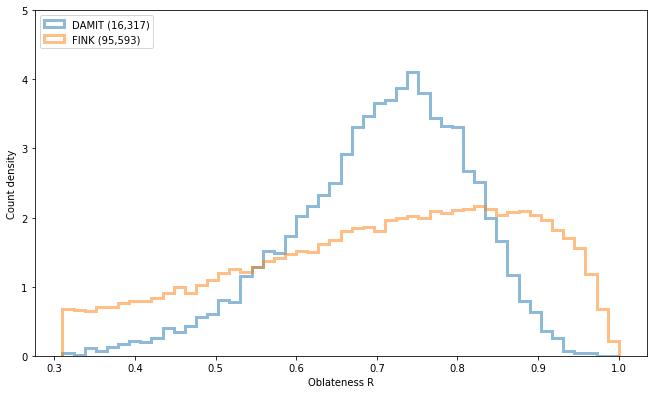

In [90]:
maskFINK = maskFINK_union

# fig, ax = plt.subplots(figsize=fs.figsize(0.5),
fig, ax = plt.subplots(
    figsize=(10, 6), gridspec_kw={"right": 0.975, "top": 0.95, "bottom": 0.15}
)

r = [0.31, 1]
b = 50

# colors = ["#15284F", "#F5622E"]


# ax.hist( damit.R, range=r, bins=b,
#         color='lightgray',
#         density=True, alpha=0.5, label=f'DAMIT ({len(damit):,d})' )

ax.hist(
    damit.R,
    range=r,
    bins=b,
#     color="slategray",
    density=True,
    alpha=0.5,
    lw=3,
    histtype='step',
    label=f"DAMIT ({len(damit):,d})",
)
# ax.hist( data.loc[maskFINK,'SHG1G2_R'], range=r, bins=b, density=True, alpha=0.5, label=f'FINK ({len(data[maskFINK]):,d})' )

cond = (data.SHG1G2_dR < 0.9) & maskFINK
ax.hist(
    data.loc[cond, "SHG1G2_R"],
    range=r,
    bins=b,
#     color=colors[0],
    lw=3,
    histtype='step',
    density=True,
    alpha=0.5,
    label=f"FINK ({len(data[maskFINK]):,d})",
)

ax.set_ylim(0, 5)
ax.set_xlabel("Oblateness R")
ax.set_ylabel("Count density")
ax.legend(loc="upper left")

# fig.savefig(f'{data_fink}plots/R_and_damit.png', facecolor='white', dpi=150)

Text(0.5, 0, '(FINK R - DAMIT R) / dR')

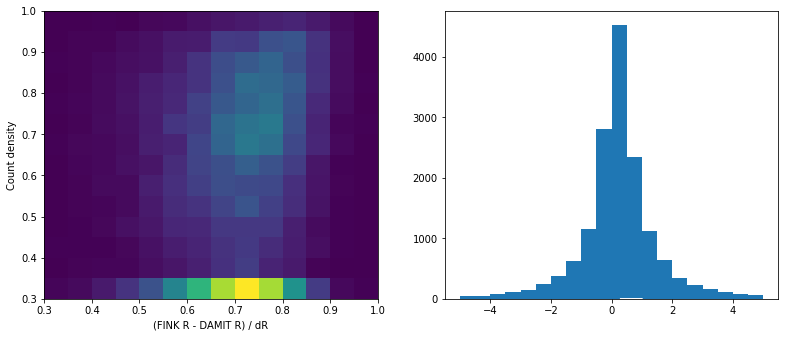

In [89]:
# fig, ax = plt.subplots(figsize=fs.figsize(0.5),
fig, ax = plt.subplots(
    1, 2, figsize=(12, 5), gridspec_kw={"right": 0.975, "top": 0.95, "bottom": 0.15}
)

r = [0, 1]
b = 50

colors = ["#15284F", "#F5622E"]

x = damit.merge(data, left_on="number", right_on="sso_number")

# ax.scatter( x.R, x.SHG1G2_R )
ax[0].hist2d(x.R, x.SHG1G2_R, range=[[0.3, 1], [0.3, 1]], bins=14)
xx = np.linspace(0.3, 1, num=10)
ax[1].plot(xx, xx, color="white")

ax[1].hist((x.R - x.SHG1G2_R) / x.SHG1G2_dR, range=[-5, 5], bins=20)


# ax.set_ylim(0,4)
ax[0].set_xlabel("FINK R")
ax[0].set_ylabel("Count density")

ax[0].set_xlabel("(FINK R - DAMIT R) / dR")

# fig.savefig(f'{data_fink}plots/R_and_damit.png', facecolor='white', dpi=150)

In [78]:
maskFINK = maskFINK_union

In [79]:
# damit.sort_values(by='R').head(40)
cond = maskFINK & (data.SHG1G2_R > 0.18)
data[cond].sort_values(by="SHG1G2_R").head(40)

,ssnamenr,HG_chi2red,HG_status,HG_fit,HG_rms,HG_rms_g,HG_rms_r,HG_median_error_phot,HG_median_error_phot_1,HG_median_error_phot_2,...,spins.delta_RA,spins.delta_DEC,spins.err_RA,spins.err_DEC,spins.RA,spins.DEC,spins.dSpin,lon_orbit,lat_orbit,obliquity
115522,73617,1.347041,4.0,0.0,0.145292,0.119996,0.163896,0.142590,0.165862,0.132778,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,NaN,NaN,NaN
75299,103476,3.857710,2.0,0.0,0.227867,0.255743,0.213395,0.134134,0.149105,0.120483,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,166.043511,88.339688,NaN
75302,134881,3.950681,2.0,0.0,0.155133,0.165442,0.148552,0.117035,0.154619,0.098781,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,262.485184,73.048343,163.871132
96597,92710,1.749134,2.0,0.0,0.098659,0.101963,0.096253,0.087308,0.099588,0.073093,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,212.672505,86.043050,NaN
114285,18446,4.516648,2.0,0.0,0.165222,0.144997,0.178409,0.102882,0.114116,0.091066,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,233.971585,88.975280,NaN
75311,215532,2.087858,2.0,0.0,0.178640,0.171969,0.181982,0.146585,0.164400,0.116284,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,174.747772,81.593239,NaN
75312,24976,7.989081,2.0,0.0,0.187439,0.152676,0.204969,0.082890,0.083060,0.073482,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,123.185047,86.105041,110.675538
114289,217801,0.793870,2.0,0.0,0.102223,0.091993,0.106727,0.135004,0.161595,0.128025,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,163.977496,84.254352,NaN
106151,94849,4.518556,2.0,0.0,0.171366,0.193931,0.159450,0.116285,0.112126,0.119999,...,-3.283020,-9.105325,30.0,30.0,236.646,236.646,34.235394,31.431805,84.086789,NaN
24287,294186,0.468324,2.0,0.0,0.077449,0.060471,0.084108,0.143768,0.165694,0.120592,...,NaN,NaN,15.0,15.0,15.000,15.000,NaN,NaN,NaN,NaN


Text(0, 0.5, 'R')

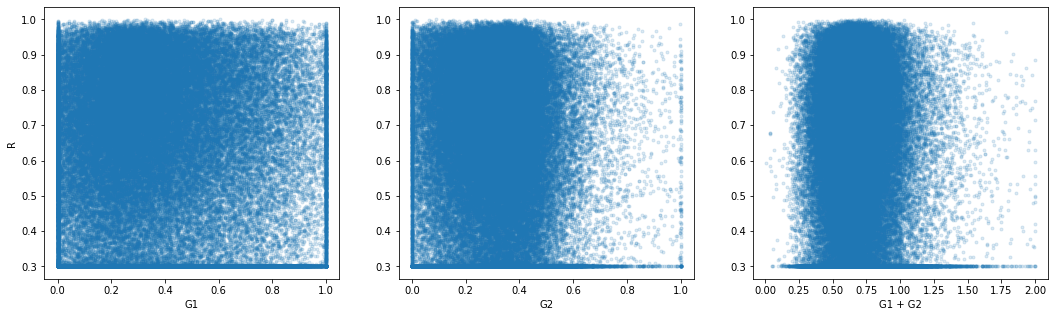

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

r = [0, 1]
b = 50


cond = maskFINK_union

ax[0].scatter(
    data.loc[cond, "SHG1G2_G1_r"], data.loc[cond, "SHG1G2_R"], marker=".", alpha=0.15
)
ax[1].scatter(
    data.loc[cond, "SHG1G2_G2_r"], data.loc[cond, "SHG1G2_R"], marker=".", alpha=0.15
)
ax[2].scatter(
    data.loc[cond, "SHG1G2_G1_r"] + data.loc[cond, "SHG1G2_G2_r"],
    data.loc[cond, "SHG1G2_R"],
    marker=".",
    alpha=0.15,
)

ax[0].set_xlabel("G1")
ax[1].set_xlabel("G2")
ax[2].set_xlabel("G1 + G2")
ax[0].set_ylabel("R")

# ax.legend(loc='upper left')

In [81]:
# fun
data[data["name"].isin(["Benoitcarry", "Julienpeloton"])][
    ["name", "SHG1G2_alpha0", "SHG1G2_delta0", "SHG1G2_R"]
]

,name,SHG1G2_alpha0,SHG1G2_delta0,SHG1G2_R
28773,Benoitcarry,231.353653,-44.892094,0.902153
121997,Julienpeloton,137.001740,-73.602005,0.606226
